In [18]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dropout, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [5]:
#tylko za 1 razem
# nltk.download('wordnet')
# nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Wczytywanie danych
train_data = pd.read_csv("jigsaw-toxic-comment-classification-challenge/train.csv")
train_data["comment_text"] = train_data["comment_text"].str.lower()
#print(train_data["comment_text"])
print("pre clean:\n\n", train_data["comment_text"])

pre clean:

 0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore\ni can't make any real suggestions on ...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159566    ":::::and for the second time of asking, when ...
159567    you should be ashamed of yourself \n\nthat is ...
159568    spitzer \n\numm, theres no actual article for ...
159569    and it looks like it was actually you who put ...
159570    "\nand ... i really don't think you understand...
Name: comment_text, Length: 159571, dtype: object


In [8]:
# Preprocessing danych
def cleaning(data):
    # remove the characters in the first parameter
    clean_column = re.sub('<.*?>', ' ', str(data))
    # removes non-alphanumeric characters except periods.
    clean_column = re.sub('[^a-zA-Z0-9.]+', ' ', clean_column)
    # tokenize
    tokenized_column = word_tokenize(clean_column)
    return tokenized_column

In [21]:
train_data["cleaned"] = train_data["comment_text"].apply(cleaning)
print("post clean:\n\n", train_data)

post clean:

                       id                                       comment_text  \
0       0000997932d777bf  [explanation, why, the, edits, made, under, my...   
1       000103f0d9cfb60f  [d, aww, he, match, this, background, colour, ...   
2       000113f07ec002fd  [hey, man, i, m, really, not, trying, to, edit...   
3       0001b41b1c6bb37e  [more, i, can, t, make, any, real, suggestion,...   
4       0001d958c54c6e35  [you, sir, are, my, hero, ., any, chance, you,...   
...                  ...                                                ...   
159566  ffe987279560d7ff  [and, for, the, second, time, of, asking, when...   
159567  ffea4adeee384e90  [you, should, be, ashamed, of, yourself, that,...   
159568  ffee36eab5c267c9  [spitzer, umm, there, no, actual, article, for...   
159569  fff125370e4aaaf3  [and, it, look, like, it, wa, actually, you, w...   
159570  fff46fc426af1f9a  [and, ..., i, really, don, t, think, you, unde...   

        toxic  severe_toxic  obscene 

In [20]:
# Lematyzacja slow
lemmatizer = WordNetLemmatizer()

def lemmatizing(data):
    # input our data in function, take the cleaned column
    my_data = data["cleaned"]
    lemmatized_list = [lemmatizer.lemmatize(word) for word in my_data]
    return (lemmatized_list)

train_data["lemmatized"] = train_data.apply(lemmatizing, axis=1)
print("post lemmatize:\n\n", train_data["lemmatized"])

train_data["comment_text"] = train_data["lemmatized"]
train = train_data[["comment_text"]]
train_labels = train_data[["toxic"]]
print(train)
print(train_labels)

post lemmatize:

 0         [explanation, why, the, edits, made, under, my...
1         [d, aww, he, match, this, background, colour, ...
2         [hey, man, i, m, really, not, trying, to, edit...
3         [more, i, can, t, make, any, real, suggestion,...
4         [you, sir, are, my, hero, ., any, chance, you,...
                                ...                        
159566    [and, for, the, second, time, of, asking, when...
159567    [you, should, be, ashamed, of, yourself, that,...
159568    [spitzer, umm, there, no, actual, article, for...
159569    [and, it, look, like, it, wa, actually, you, w...
159570    [and, ..., i, really, don, t, think, you, unde...
Name: lemmatized, Length: 159571, dtype: object
                                             comment_text
0       [explanation, why, the, edits, made, under, my...
1       [d, aww, he, match, this, background, colour, ...
2       [hey, man, i, m, really, not, trying, to, edit...
3       [more, i, can, t, make, any, real,

In [11]:
 # 2. Używanie train_test_split w celu podziału na podzbior testowy i treningowy
comment_train, comment_test, labels_train, labels_test = train_test_split(train, train_labels, test_size=0.2,
                                                                          random_state=42)
# Transpozycja itp w celu zmiany macierzy do odpowiedniej formy
labels_train = np.transpose(labels_train)
labels_train = np.ravel(labels_train)
labels_test = np.transpose(labels_test)
labels_test = np.ravel(labels_test)

In [12]:
# 3. CountVectorizer
count_vect = CountVectorizer()
comment_train_counts = count_vect.fit_transform(comment_train.comment_text.astype(str))
print(comment_train_counts)

  (0, 59372)	3
  (0, 132633)	3
  (0, 121844)	1
  (0, 25741)	1
  (0, 67740)	1
  (0, 136244)	2
  (0, 70748)	1
  (0, 62154)	1
  (0, 63119)	1
  (0, 134938)	1
  (0, 62865)	1
  (0, 6641)	1
  (0, 6739)	1
  (0, 6817)	1
  (0, 4984)	1
  (1, 67740)	1
  (1, 70748)	1
  (1, 134938)	5
  (1, 85178)	1
  (1, 2725)	1
  (1, 141033)	1
  (1, 71074)	1
  (1, 147886)	3
  (1, 19889)	3
  (1, 45223)	1
  :	:
  (127654, 103102)	1
  (127654, 127929)	1
  (127654, 32135)	1
  (127654, 15520)	1
  (127654, 80929)	1
  (127654, 55949)	1
  (127654, 95742)	1
  (127654, 123374)	1
  (127654, 87166)	1
  (127655, 67740)	1
  (127655, 70748)	1
  (127655, 149637)	1
  (127655, 133105)	1
  (127655, 12916)	1
  (127655, 15071)	1
  (127655, 148153)	1
  (127655, 86513)	1
  (127655, 97959)	1
  (127655, 73758)	1
  (127655, 35328)	1
  (127655, 35290)	1
  (127655, 129319)	1
  (127655, 133878)	1
  (127655, 42997)	1
  (127655, 39863)	1


In [13]:
#4. TfidfTransformer
#Use tf-idf instead
tf_transformer = TfidfTransformer(use_idf=False).fit(comment_train_counts)
comment_train_tf = tf_transformer.transform(comment_train_counts)

tfidf_transformer = TfidfTransformer()
comment_train_tfidf = tfidf_transformer.fit_transform(comment_train_counts)

In [14]:
# Naive Bayes classifier
# tworzenie modelu
clf = MultinomialNB().fit(comment_train_tfidf, labels_train)

# pakowanie slow w paczki
comment_test_new_counts = count_vect.transform(comment_test.comment_text.astype(str))
comment_test_new_tfidf = tfidf_transformer.transform(comment_test_new_counts)

In [15]:
#6 Trenowanie modelu LSTM
num_words = 20000
max_len = 150
emb_size = 128

# vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) 
# or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf
tok = Tokenizer(num_words = num_words, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tok.fit_on_texts(list(comment_train.comment_text.astype(str)))

comment_train2 = tok.texts_to_sequences(comment_train.comment_text.astype(str))
comment_test2 = tok.texts_to_sequences(comment_test.comment_text.astype(str))

comment_train2 = sequence.pad_sequences(comment_train2, maxlen = max_len)
comment_test2 = sequence.pad_sequences(comment_test2, maxlen = max_len)


inp = Input(shape = (max_len, ))
layer = Embedding(num_words, emb_size)(inp)
layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50, activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation = 'sigmoid')(layer)
model = Model(inputs = inp, outputs = layer)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print("\n")
model.summary()

file_path = 'save_best_model_lstm.keras'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

model.fit(comment_train2, labels_train, batch_size = 512, epochs = 5, validation_split = 0.2, validation_data = (comment_test2, labels_test), callbacks = [checkpoint, early_stop])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 100)       │        71,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,636,701 (10.06 MB)

 Trainable params: 2,636,701 (10.06 MB)

 Non-trainable params: 0 (0.00 B)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8800 - loss: 0.3271
Epoch 1: val_loss improved from inf to 0.10735, saving model to save_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.8802 - loss: 0.3267 - val_accuracy: 0.9624 - val_loss: 0.1073


In [ ]:
 #6 Prediction:
prediction_nb = clf.predict(comment_test_new_tfidf)
prediction_lstm = (model.predict(comment_test2).ravel()>0.5)+0 

cm_nb = metrics.confusion_matrix(labels_test, prediction_nb)
cmd_nb = ConfusionMatrixDisplay(cm_nb, display_labels=["non_toxic", "toxic"])
cmd_nb.plot()
plt.savefig("CM_NB.png")

cm_lstm = confusion_matrix(labels_test, prediction_lstm)
cmd_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=["non_toxic", "toxic"])
cmd_lstm.plot()
plt.savefig("CM_LSTM.png")

plt.show()

with open("output.txt", "w") as f:
    print("NB Accuracy:", file=f)
    print(np.mean(prediction_nb == labels_test), file=f)
    print("\n", file=f)
    print("NB Precision, Recall, and F1 Score:", file=f)
    print(metrics.classification_report(labels_test, prediction_nb), file=f)
    print("NB Confusion Matrix:", file=f)
    print(cm_nb, file=f)
    print("\n", file=f)

    print("LSTM Accuracy:", file=f)
    print(np.mean(prediction_lstm == labels_test), file=f)
    print("\n", file=f)
    print("LSTM Precision, Recall, and F1 Score:", file=f)
    print(metrics.classification_report(labels_test, prediction_lstm), file=f)
    print("LSTM Confusion Matrix:", file=f)
    print(cm_lstm, file=f)


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8955 - loss: 0.3067
Epoch 1: val_loss improved from inf to 0.12422, saving model to save_best_model_cnn.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.8956 - loss: 0.3063 - val_accuracy: 0.9549 - val_loss: 0.1242
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9605 - loss: 0.1083
Epoch 2: val_loss improved from 0.12422 to 0.11550, saving model to save_best_model_cnn.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9605 - loss: 0.1083 - val_accuracy: 0.9590 - val_loss: 0.1155
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9692 - loss: 0.0790
Epoch 3: val_loss did not improve from 0.11550
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9692 - loss: 0.0790 - val_accuracy: 0.9574 - val_loss: 0.1239
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


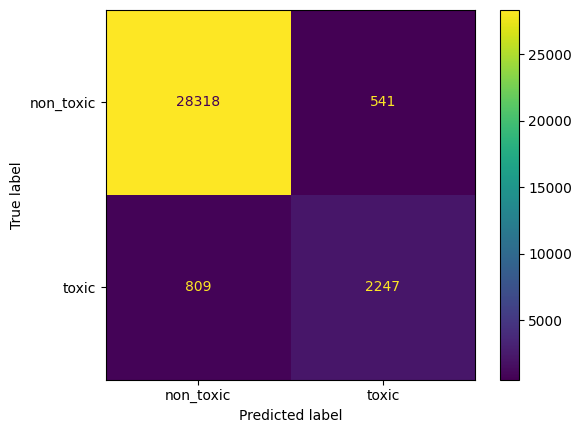

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [19]:
# CNN model
num_words = 20000
max_len = 150
emb_size = 128

tok = Tokenizer(num_words=num_words, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tok.fit_on_texts(list(comment_train.comment_text.astype(str)))

comment_train2 = tok.texts_to_sequences(comment_train.comment_text.astype(str))
comment_test2 = tok.texts_to_sequences(comment_test.comment_text.astype(str))

comment_train2 = sequence.pad_sequences(comment_train2, maxlen=max_len)
comment_test2 = sequence.pad_sequences(comment_test2, maxlen=max_len)

inp_cnn = Input(shape=(max_len,))
layer_cnn = Embedding(num_words, emb_size)(inp_cnn)
layer_cnn = Conv1D(128, 5, activation='relu')(layer_cnn)
layer_cnn = MaxPooling1D(5)(layer_cnn)
layer_cnn = Conv1D(128, 5, activation='relu')(layer_cnn)
layer_cnn = GlobalMaxPooling1D()(layer_cnn)
layer_cnn = Dropout(0.2)(layer_cnn)
layer_cnn = Dense(50, activation='relu')(layer_cnn)
layer_cnn = Dropout(0.2)(layer_cnn)
layer_cnn = Dense(1, activation='sigmoid')(layer_cnn)
model_cnn = Model(inputs=inp_cnn, outputs=layer_cnn)
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

file_path_cnn = 'save_best_model_cnn.keras'
checkpoint_cnn = ModelCheckpoint(file_path_cnn, monitor='val_loss', verbose=1, save_best_only=True)
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=1)

model_cnn.fit(comment_train2, labels_train, batch_size=512, epochs=5, validation_split=0.2, callbacks=[checkpoint_cnn, early_stop_cnn])

# Prediction with CNN
prediction_cnn = (model_cnn.predict(comment_test2).ravel() > 0.5).astype(int)

cm_cnn = confusion_matrix(labels_test, prediction_cnn)
cmd_cnn = ConfusionMatrixDisplay(cm_cnn, display_labels=["non_toxic", "toxic"])
cmd_cnn.plot()
plt.savefig("CM_CNN.png")

plt.show()

# Output results to file
with open("output_cnn.txt", "w") as f:
    print("CNN Cross-Validation Accuracies:", file=f)
    for i, acc in enumerate(cnn_accuracies, 1):
        print(f"Fold {i} Accuracy: {acc}", file=f)
    print(f"\nAverage CNN Accuracy: {np.mean(cnn_accuracies)}", file=f)
